In [1]:
import sys
print(sys.version)

import tensorflow as tf
print(tf.__version__)

import numpy as np
np.set_printoptions(threshold=np.inf)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:52:09) 
[Clang 14.0.6 ]
2.12.0


In [ ]:
"""
1. 交叉验证
交叉验证主要防止模型过于复杂而引起的过拟合，找到使模型泛化能力最优的参数。我们将数据划分为训练集、验证集、测试集。训练集用于输入网络模型作为样本进行学习。
验证集是在迭代过程中对模型进行评估，寻找最优解。测试集是在整个网络训练完成后进行评估。

K折交叉验证，就是将训练集数据等比例划分成K份，以其中的1份作为验证数据，其他的K-1份数据作为训练数据。每次迭代从都是从K个部分选取一份不同的数据部分作为测试数据，
剩下的K-1个当作训练数据，最后把得到的K个实验结果进行平分。
"""

In [3]:
"""
（1）构造数据集时划分
首先导入训练集(x,y)和测试集(x_test, y_test)，K折交叉验证是对测试集的划分，指定迭代500次，每次迭代都从训练集中选出一部分作为验证数据ds_val，
剩下的作为训练数据ds_train。使用tf.random.shuffle() 随机打乱索引顺序，不影响x和y之间的对应关系。tf.gather()根据索引来选取值。
"""
from tensorflow import keras
from tensorflow.keras import datasets,layers,optimizers,Sequential,metrics
# 以手写数字为例，获取训练集和测试集
(x,y),(x_test,y_test) = datasets.mnist.load_data()
 
# 预处理函数
def processing(x,y): 
    # 从[0,255]=>[-1,1]
    x = 2 * tf.cast(x, dtype=tf.float32) / 255.0 - 1
    y = tf.cast(y, dtype=tf.int32)
    return(x,y)
 
# 交叉验证K=500
for epoch in range(500):
 
    idx = tf.range(60000) # 假设training数据一共有60k张图象，生成索引
    idx = tf.random.shuffle(idx) # 随机打乱索引
    
    # 利用随机打散的索引来收集数据，不改变xy之间的关联
    x_train, y_train = tf.gather(x, idx[:50000]), tf.gather(y, idx[:50000])
    x_val, y_val = tf.gather(x, idx[-10000:]), tf.gather(y, idx[-10000:])
    
    # 构建训练集
    ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))  # 自动将输入的xy转变成tenosr类型
    ds_train = ds_train.map(processing).shuffle(10000).batch(128) # 对数据集中的所有数据使用预处理函数
    
    # 构建验证集
    ds_val = tf.data.Dataset.from_tensor_slices((x_val, y_val))  
    ds_val = ds_val.map(processing).batch(128) # 每次迭代取128组数据，验证不需要打乱数据

In [ ]:
"""
（2）使用训练函数fit()中的参数划分
如果嫌使用上面的方法构造数据集太麻烦的话，可以在模型训练函数fit()中指定划分方式validation_split=0.1，每次迭代取0.1倍的训练数据作为验证集，剩下的作为训练集。
ds_train_val 要求是没有被划分过的训练集数据。这样的话就不需要再指定validation_data验证集数据了，在划分时自动生成。
"""
# ds_train_val指没有划分过的train和val数据集，validation_split=0.1动态切割，0.1比例的数据分给val
network.fit(ds_train_val, epochs=6, validation_split=0.1, validation_freq=2)
# 不需要再指定validation_data，已经在被包含在validation_split中了
"""
在模型迭代过程中使用验证集来查看什么时候模型效果最优，找到最优的就跳出循环。验证集在挑选模型参数的时候，
先保存误差极小值对应的权重，如果后面检测到的误差都大于它，就使用当前这个权重。
"""

In [ ]:
"""
2. 正则化
当采用比较复杂的模型，去拟合数据时，很容易出现过拟合现象，这会导致模型的泛化能力下降，对模型添加正则化项可以限制模型的复杂度，使得模型在复杂度和性能达到平衡。

原理： https://blog.csdn.net/red_stone1/article/details/80755144?utm_medium=distribute.pc_relevant.none-task-blog-2~default~baidujs_baidulandingword~default-4.no_search_link&spm=1001.2101.3001.4242.3


L1正则化是在原来的损失函数基础上加上权重参数的绝对值。L1可以产生0解，L1获得稀疏解。
J(θ)=J(w,x,y)+λ∑ni=1|wi|

L2正则化是在原来的损失函数基础上加上权重参数的平方和。L2可以产生趋近0的解，L2获得非零稠密解。
J(θ)=J(w,x,y)+λ∑ni=1w2i
"""

"""
在构建网络层时指定正则化参数kernel_regularizer，使用二范数的方法keras.regularizers.l2，惩罚系数0.01。
"""
# 使用二范数正则化，loss = loss + 0.001*regularizer，指定正则化的权重
model = keras.Sequential([
    keras.layers.Dense(32, kernel_regularizer=keras.regularizers.l2(0.001), activation=tf.nn.relu),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001), activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)])

170498071/170498071 [==============================] - 30s 0us/step
x.shape: (50000, 32, 32, 3), y.shape: (50000, 1)
x_test.shape: (10000, 32, 32, 3), y_test.shape: (10000, 1)
y[:5]: [[6]
 [9]
 [9]
 [4]
 [1]]


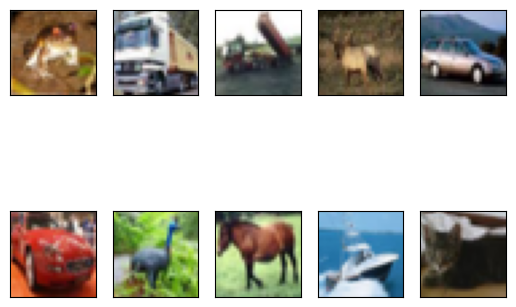

In [5]:
"""
3. 自定义网络
3.1 数据获取
首先导入我们需要的库文件，从系统中导入图片数据，划分测试集和训练集。
"""
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, optimizers, Sequential, metrics
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # 输出框只输出有意义的信息
 
#（1）数据获取
(x,y),(x_test,y_test) = datasets.cifar10.load_data() #获取图像分类数据
# 查看数据信息
print(f'x.shape: {x.shape}, y.shape: {y.shape}')  #查看训练集的维度信息
print(f'x_test.shape: {x_test.shape}, y_test.shape: {y_test.shape}')  #测试集未读信息
print(f'y[:5]: {y[:5]}')  #查看训练集目标的前5项
# 绘图展示
import matplotlib.pyplot as plt
for i in range(10): # 展示前10张图片
    plt.subplot(2,5,i+1)  # 2行5列第i+1个位置
    plt.imshow(x[i])
    plt.xticks([]) # 不显示x和y轴坐标刻度
    plt.yticks([])
 
# 输入的图像形状
# x.shape: (50000, 32, 32, 3), y.shape: (50000, 1)
# x_test.shape: (10000, 32, 32, 3), y_test.shape: (10000, 1)
#需要训练的图片如下，图片本身不清晰，这里只说一下基本的自定义网络的构造，最多只有80%准确率，模型优化到卷积神经网络章节再谈。

In [7]:
"""
3.2 数据预处理
由于导入的目标值y的shape时二维[50k,1]，需要将axis=1的轴压缩掉，变成一个一维的向量[50k]，使用tf.squeeze()压缩指定轴，
对目标值one-hot编码对应索引的值变为1，其他索引对应的值变为0，shape变为[b,10]。把特征值x的范围映射到[-1,1]之间。
"""
#（2）数据预处理
# 定义预处理函数
def processing(x,y): 
    # 由于目标数据是而二维的，把shape=1的轴删除，从向量变成标量
    y = tf.squeeze(y)  # 默认压缩所有维度为1的轴，shape为[50k]
    y = tf.one_hot(y, depth=10) # one-hot编码，分成10个类别，shape为[50k,10]，对应下标所在的值为1
    # 每个像素值的范围在[-1,1]之间，从[0,255]=>[-1,1]
    x = 2 * tf.cast(x, dtype=tf.float32) / 255.0 - 1
    y = tf.cast(y, dtype=tf.int32)
    return(x,y)
 
# 构建训练集数据集
ds_train = tf.data.Dataset.from_tensor_slices((x, y))  # 自动将输入的xy转变成tenosr类型
ds_train = ds_train.map(processing).batch(128).shuffle(10000)  # 对数据集中的所有数据使用预处理函数
 
# 构建测试集数据集
ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))  
ds_test = ds_test.map(processing).batch(128) # 每次迭代取128组数据，测试不需要打乱数据
 
# 构造迭代器，查看数据集是否正确
sample = next(iter(ds_train))  # 每次运行从训练数据集中取出一组xy
print('x_batch.shape', sample[0].shape, 'y_batch.shape', sample[1].shape)
# x_batch.shape (128, 32, 32, 3)   y_batch.shape (128, 10)

x_batch.shape (128, 32, 32, 3) y_batch.shape (128, 10)


In [10]:
"""
3.3 自定义网络
"""
#（3）构造网络
class MyDense(layers.Layer): #必须继承layers.Layer层，放到sequential容器中
    # 代替layers.Dense层
    def __init__(self, input_dim, output_dim):
        super(MyDense, self).__init__()   # 调用母类初始化，必须
 
        # 自己发挥'w''b'指定名字没什么用，创建shape为[input_dim, output_dim的权重
        # 使用add_variable创建变量        
        self.kernel = self.add_weight('w',[input_dim, output_dim])
        self.bias = self.add_weight('b', [output_dim])
 
    # call方法，training来指示现在是训练还是测试         
    def call(self, inputs, training=None):
        
        x = inputs @ self.kernel + self.bias
        
        return x
 
# 自定义网络层
class MyNetwork(keras.Model):  # 必须继承keras.Model大类，才能使用complie、fit等功能
    
    def __init__(self):
        super(MyNetwork, self).__init__()  # 调用父类Mymodel
        # 新建五个层次
        self.fc1 = MyDense(32*32*3, 256)  #input_dim=784，output_dim=256
        self.fc2 = MyDense(256, 128)
        self.fc3 = MyDense(128, 64)
        self.fc4 = MyDense(64, 32)        
        self.fc5 = MyDense(32, 10)
  
    def call(self, inputs, training=None):
        # 前向传播，可以接收四维的tensor
        x = tf.reshape(inputs, [-1,32*32*3]) # 改变输入特征的形状
        x = self.fc1(x) #第一层[b,32*32*3]==>[b,256]
        x = tf.nn.relu(x) #激活函数
        x = self.fc2(x)
        x = tf.nn.relu(x)
        x = self.fc3(x)
        x = tf.nn.relu(x)
        x = self.fc4(x)
        x = tf.nn.relu(x)
        x = self.fc5(x)  #logits层
        return x

In [11]:
"""
3.4 网络配置
"""
#（4）网络配置
network = MyNetwork()       
network.compile(optimizer = optimizers.legacy.Adam(learning_rate=0.001),  # 指定优化器
                loss = tf.losses.CategoricalCrossentropy(from_logits=True), #交叉熵损失
                metrics = ['accuracy'])  # 测试指标     
 
#（5）网络训练，输入训练数据，循环5次，验证集为ds_test，每一次大循环做一次测试
network.fit(ds_train, epochs=5, validation_data=ds_test, validation_freq=1)
 
# 循环5次后的结果为
# Epoch 5/5
# 391/391 [==============================] - 3s 8ms/step - loss: 1.2197 - accuracy: 0.5707 - val_loss: 1.3929 - val_accuracy: 0.5182

Epoch 1/5
391/391 [==============================] - 2s 4ms/step - loss: 1.7141 - accuracy: 0.3941 - val_loss: 1.5559 - val_accuracy: 0.4492
Epoch 2/5
391/391 [==============================] - 2s 4ms/step - loss: 1.4850 - accuracy: 0.4764 - val_loss: 1.4839 - val_accuracy: 0.4810
Epoch 3/5
391/391 [==============================] - 2s 4ms/step - loss: 1.3772 - accuracy: 0.5147 - val_loss: 1.4226 - val_accuracy: 0.5031
Epoch 4/5
391/391 [==============================] - 2s 4ms/step - loss: 1.2922 - accuracy: 0.5440 - val_loss: 1.3930 - val_accuracy: 0.5146
Epoch 5/5
391/391 [==============================] - 2s 4ms/step - loss: 1.2119 - accuracy: 0.5694 - val_loss: 1.3718 - val_accuracy: 0.5240
